In [68]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

### Conducting a statistical analysis of a linear regression model

Random model

In [69]:
# importing dataframe
path = r'.\usina.csv'
df = pd.read_csv(path)
df

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90
...,...,...,...,...,...
9563,16.65,49.69,1014.01,91.00,460.03
9564,13.19,39.18,1023.67,66.78,469.62
9565,31.32,74.33,1012.92,36.48,429.57
9566,24.48,69.45,1013.86,62.39,435.74


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


Let's consider PE as our target variable for predictions.

In [70]:
y = df['PE']
X = df.drop(columns = 'PE')

Correlation dashboard

In [71]:
corr = df.corr()

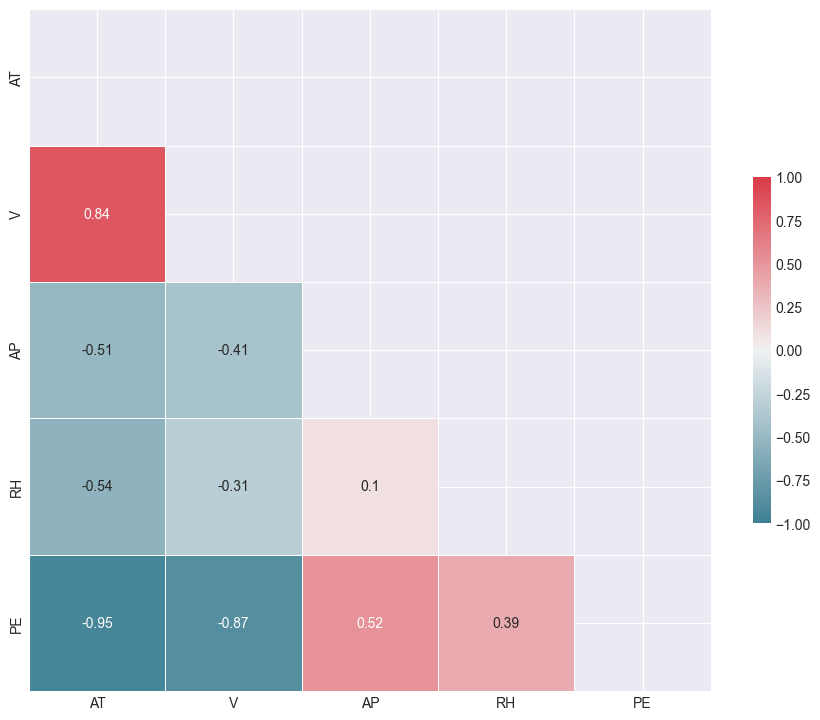

In [72]:
# generating mask, hiding superior triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# sizing...
f, ax = plt.subplots(figsize=(11, 9))

# creating heatmap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, vmin = -1, center = 0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})
plt.style.use('seaborn-v0_8-darkgrid')
# plot!
plt.show()

Pairplots for PE

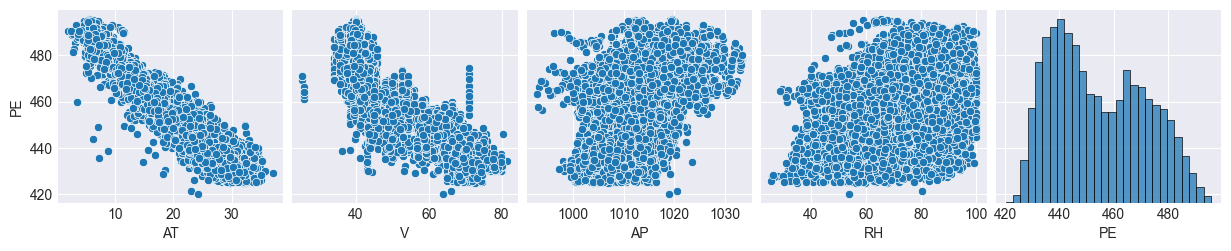

In [89]:
sns.pairplot(df, y_vars = 'PE')
plt.show()

Checking correlations with PE

In [74]:
corr['PE']

AT   -0.948128
V    -0.869780
AP    0.518429
RH    0.389794
PE    1.000000
Name: PE, dtype: float64

We found a strong inverse relationship between AT, V and PE.

Creating  linear regression prediction model

In [75]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 214)

In [76]:
# adding constant
X_train = sm.add_constant(X_train)

# modeling...
model = sm.OLS(y_train, X_train).fit()

In [77]:
# summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 2.154e+04
Date:                Mon, 16 Dec 2024   Prob (F-statistic):               0.00
Time:                        13:50:23   Log-Likelihood:                -19709.
No. Observations:                6697   AIC:                         3.943e+04
Df Residuals:                    6692   BIC:                         3.946e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        461.3238     11.647     39.607      0.0

Despite a high R-squared and a low p-value, summary told us => (**)[2] The condition number is large, 2.11e+05. This might indicate that there are
strong multicollinearity or other numerical problems.<br>(**)
<br>
We should check for multicolinearity - we're going to use vif

In [78]:
# importing our vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [79]:
X_train.columns

Index(['const', 'AT', 'V', 'AP', 'RH'], dtype='object')

In [80]:
# creating and manipulating the vif dataframe
vif = pd.DataFrame()
cols = ['const', 'AT', 'V', 'AP', 'RH']
vif['variabel'] = cols


# applying vif
vif['vif'] = [variance_inflation_factor(X_train[cols], i) for i in range(len(cols))]
vif

,variabel,vif
0,const,43081.289167
1,AT,6.056868
2,V,3.995781
3,AP,1.469274
4,RH,1.687094


We can identify a moderate to high multicollinearity between (AT) and (V) variables. 

Despite the observed multicollinearity, wich is impairing our model's performance, we will proceed with making predictions to assess the residual and gain further insights into the model's limitantion

In [82]:
# adding constant
X_test = sm.add_constant(X_test)

# predicting PE with model
preds = model.predict(X_test)
preds

5881    479.757570
8845    439.827218
447     466.821443
3222    451.508765
3773    448.149768
           ...    
6535    473.029430
4524    458.759651
4215    455.243511
9102    466.951413
8341    459.169379
Length: 2871, dtype: float64

First classic visualization - Scatterplot

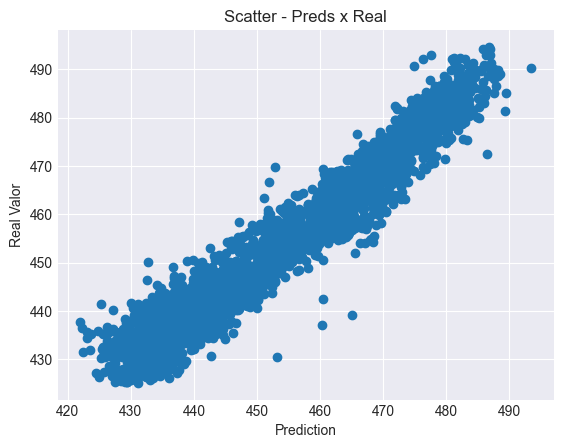

In [84]:
plt.scatter(preds, y_test)
plt.title('Scatter - Preds x Real')
plt.xlabel('Prediction')
plt.ylabel('Real Valor')
plt.show()

Nice Scatterplot!

Let's check residuals

In [85]:
# calculating residuals
residuals = preds - y_test
residuals

5881   -0.982430
8845    5.227218
447     3.721443
3222    4.838765
3773   -2.420232
          ...   
6535    1.879430
4524    4.179651
4215   -2.256489
9102    2.141413
8341    4.189379
Length: 2871, dtype: float64

Scatter - residuals x predicts

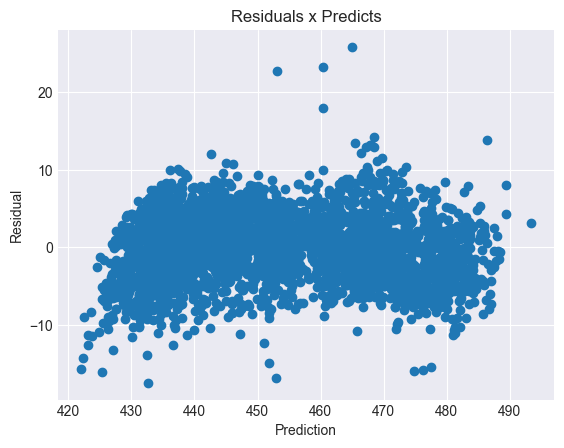

In [86]:
plt.scatter(preds, residuals)
plt.title('Residuals x Predicts')
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.show()

Is there heteroscedasticit?

Residuals Histogram

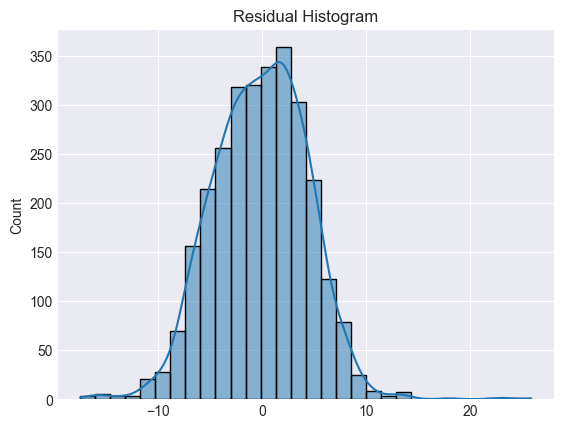

In [88]:
sns.histplot(residuals, kde = True, bins = 30)
plt.title('Residual Histogram')
plt.show()

There is a positive skew evident in the distribution. In conjunction with the scatterplot, we suspect the presence of outliers may be contributing to this skew.

And finally, QQ-Plot - checking for gaussian distribution

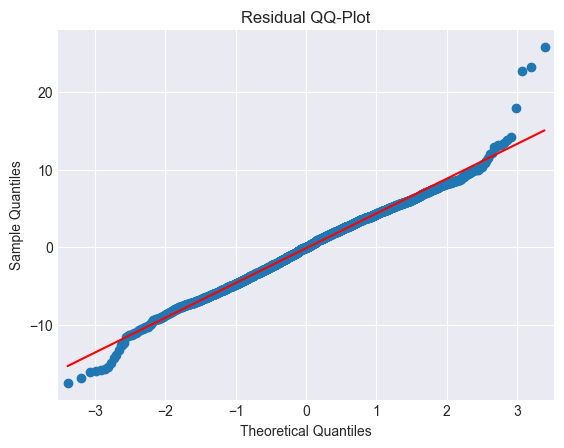

In [91]:
import statsmodels.api as sm
sm.qqplot(residuals, line = 's')
plt.title('Residual QQ-Plot')
plt.show()

The distribution exhibits non-Gaussian behavior on both tails, suggesting the influence of outliers.

In conclusion, the model has shown promising results within a specific range of our dataset. However, multicollinearity and outliers may be impairing the model's overall performance. To address these issues, we will conduct a more in-depth EDA and explore various statistical techniques, such as feature selection or outlier detection. These analyses will be documented in a separate notebook.